## Data Understanding

In this phase, data is collected and analyzed to gain insights and inform the modeling process. This phase includes:

Gather Data: Identify and collect data from various sources related to the problem. This may involve data from internal databases, external providers, or a combination of both.

Validate Data: Ensure the quality of the data by addressing missing values, correcting errors, and handling outliers. This step ensures the reliability of the subsequent analysis.

Explore the Data: Conduct exploratory data analysis (EDA) using statistical methods and visualization techniques to see the patterns, relationships, and initial insights.

In [1]:
import pandas as pd

file_path = "dataset.xlsx"

# Load data
ib_data = pd.read_excel(file_path, sheet_name="DATA IB")
ik_data = pd.read_excel(file_path, sheet_name="DATA IK")

# Ambil kolom yang relevan dan ubah nama
ib_data = ib_data[["desc"]].rename(columns={"desc": "keperluan"})
ik_data = ik_data[["tujuan"]].rename(columns={"tujuan": "keperluan"})

# Tambahkan kolom penanda
ib_data["izin"] = "IB"
ik_data["izin"] = "IK"

# Gabungkan data
combined_data = pd.concat([ib_data, ik_data], ignore_index=True)

# Pembersihan teks
combined_data["keperluan"] = combined_data["keperluan"].str.strip().str.lower()

# Validasi data
print("Jumlah nilai kosong per kolom:")
print(combined_data.isnull().sum())

# Hapus nilai kosong
combined_data.dropna(subset=["keperluan"], inplace=True)

# Hapus duplikat
combined_data.drop_duplicates(subset=["keperluan"], inplace=True)

# Periksa distribusi kategori
print("\nDistribusi kategori izin:")
print(combined_data["izin"].value_counts())

# Simpan data gabungan
combined_data.to_csv("combined_ib_ik_keperluan.csv", index=False)

# Tampilkan data acak
print("\nData sampel:")
print(combined_data.sample(5))


Jumlah nilai kosong per kolom:
keperluan    0
izin         0
dtype: int64

Distribusi kategori izin:
izin
IB    2271
IK    1168
Name: count, dtype: int64

Data sampel:
                                   keperluan izin
17601  libur lebaran ke rumah orang tua asuh   IB
77557           liburan hari raya idul fitri   IB
10853                        libur idul adha   IB
79600                 melayat ke rumah teman   IK
78857                 medical check up (mcu)   IK


 ## Exploratory Data Analysis (EDA)

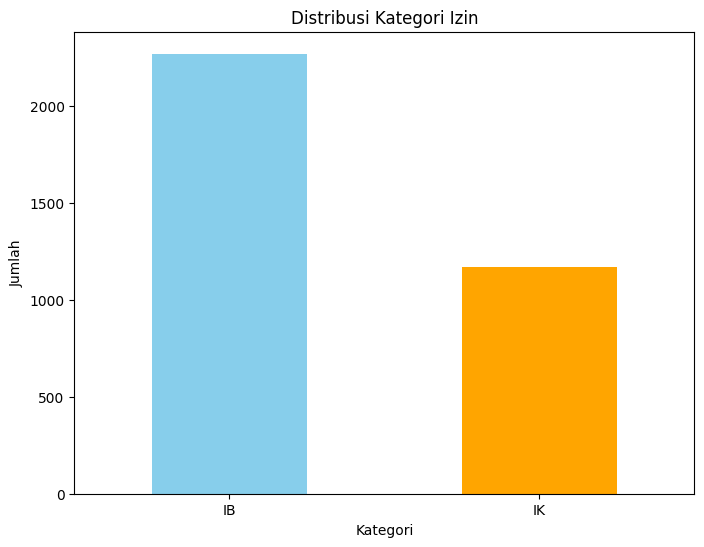

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi kategori izin
category_counts = combined_data["izin"].value_counts()
category_counts.plot(kind="bar", color=["skyblue", "orange"], figsize=(8, 6))
plt.title("Distribusi Kategori Izin")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.show()


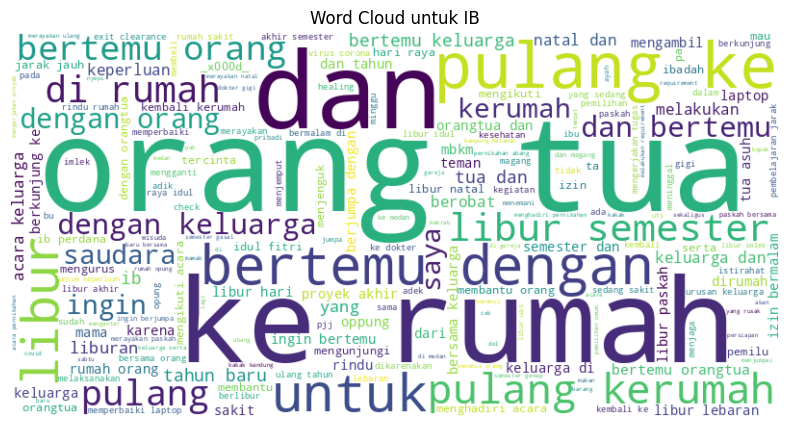

10 Kata Paling Umum dalam Keperluan IB:
dan: 533
libur: 370
rumah: 341
ke: 339
keluarga: 331
bertemu: 327
orang: 318
pulang: 314
tua: 283
dengan: 196


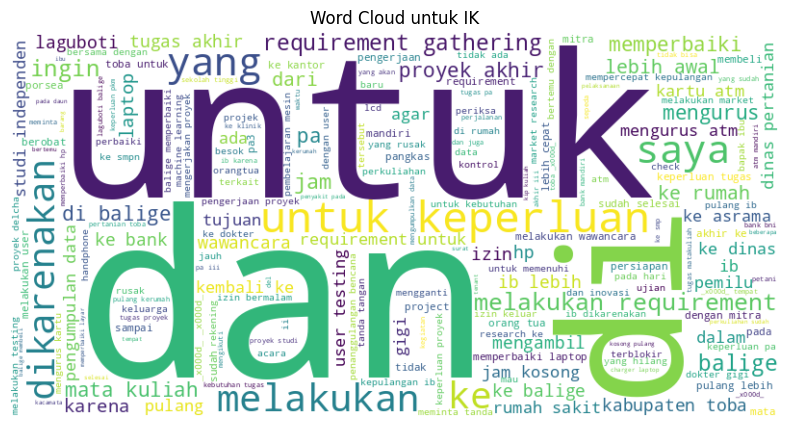

10 Kata Paling Umum dalam Keperluan IK:
untuk: 367
ke: 339
dan: 274
melakukan: 231
di: 179
keperluan: 171
requirement: 149
yang: 146
balige: 140
proyek: 113


In [3]:
from wordcloud import WordCloud
from collections import Counter

# Gabungkan teks berdasarkan izin
text_ib = " ".join(combined_data[combined_data["izin"] == "IB"]["keperluan"])
text_ik = " ".join(combined_data[combined_data["izin"] == "IK"]["keperluan"])

word_counts_ib = Counter(text_ib.split())
word_counts_ik = Counter(text_ik.split())


# Word Cloud untuk IB
wordcloud_ib = WordCloud(width=800, height=400, background_color="white").generate(text_ib)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ib, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud untuk IB")
plt.show()

# Tampilkan kata paling umum
common_words_ib = word_counts_ib.most_common(10)
print("10 Kata Paling Umum dalam Keperluan IB:")
for word, count in common_words_ib:
    print(f"{word}: {count}")

# Word Cloud untuk IK
wordcloud_ik = WordCloud(width=800, height=400, background_color="white").generate(text_ik)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ik, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud untuk IK")
plt.show()

# Tampilkan kata paling umum
common_words_ik = word_counts_ik.most_common(10)
print("10 Kata Paling Umum dalam Keperluan IK:")
for word, count in common_words_ik:
    print(f"{word}: {count}")


## Data Preparation

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF Vectorization untuk field 'keperluan'
tfidf = TfidfVectorizer(
    max_features=500,  # Maksimal fitur untuk clustering
    stop_words='english',  # Menggunakan stopwords standar bahasa Inggris
    min_df=2,  # Menghilangkan kata yang jarang muncul
    max_df=0.8  # Menghilangkan kata yang terlalu sering muncul
)

# Transform field 'keperluan'
X = tfidf.fit_transform(combined_data["keperluan"]).toarray()

# Pembagian data menjadi train dan test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print(f"Ukuran data training: {X_train.shape}")
print(f"Ukuran data testing: {X_test.shape}")

Ukuran data training: (2751, 500)
Ukuran data testing: (688, 500)


## Feature Engineering

In [5]:
import pandas as pd
import re

# Fungsi klasifikasi keperluan
def classify_keperluan(text):
    if re.search(r"(laptop|printer|buku|barang)", text):
        return "Membeli Barang"
    elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2|pa 3|tugas akhir|akhir)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|behel|cabut|sakit)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(atm|rekening|tabungan|kartu)", text):
        return "Mengurus Kartu Bank"
    elif re.search(r"(exit|clearance|wisuda)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

# Baca dataset hasil sebelumnya
data = pd.read_csv("combined_ib_ik_keperluan.csv")

# Tambahkan kolom kategori
data["kategori"] = data["keperluan"].apply(classify_keperluan)

# Simpan dataset baru
data.to_csv("categorized_keperluan.csv", index=False)

# Tampilkan distribusi kategori
print(data["kategori"].value_counts())


kategori
Bertemu Keluarga       1931
Lainnya                 803
Tugas Kuliah            352
Membeli Barang          149
Mengurus Kartu Bank      92
Pergi ke Klinik          91
Tamat Kuliah             21
Name: count, dtype: int64


In [9]:
from sklearn.preprocessing import OneHotEncoder
data = pd.read_csv("categorized_keperluan.csv")

# Encode kolom kategori
encoder = OneHotEncoder()
kategori_encoded = encoder.fit_transform(data[["kategori"]]).toarray()

# Gabungkan dengan TF-IDF dari 'keperluan'
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(data["keperluan"]).toarray()

# Gabungkan fitur TF-IDF dan kategori
import numpy as np
features = np.hstack((tfidf_matrix, kategori_encoded))

# Periksa dimensi fitur
print("Dimensi fitur:", features.shape)


Dimensi fitur: (3439, 507)


In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(features)
kmeans_score = silhouette_score(features, kmeans_labels)
print(f"Silhouette Score K-Means: {kmeans_score}")

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
agg_labels = agg_clustering.fit_predict(features)
agg_score = silhouette_score(features, agg_labels)
print(f"Silhouette Score Agglomerative: {agg_score}")


Silhouette Score K-Means: 0.1679270432964557
Silhouette Score Agglomerative: 0.1581777763249906


In [8]:
data["kmeans_cluster"] = kmeans_labels
data["agg_cluster"] = agg_labels

# Analisis distribusi kategori dalam cluster
for cluster_id in range(10):
    print(f"Cluster {cluster_id} K-Means:")
    print(data[data["kmeans_cluster"] == cluster_id]["kategori"].value_counts())
    print("\n")


Cluster 0 K-Means:
kategori
Bertemu Keluarga    67
Name: count, dtype: int64


Cluster 1 K-Means:
kategori
Lainnya    803
Name: count, dtype: int64


Cluster 2 K-Means:
kategori
Tugas Kuliah    352
Name: count, dtype: int64


Cluster 3 K-Means:
kategori
Bertemu Keluarga    150
Name: count, dtype: int64


Cluster 4 K-Means:
kategori
Bertemu Keluarga    349
Name: count, dtype: int64


Cluster 5 K-Means:
kategori
Bertemu Keluarga    309
Name: count, dtype: int64


Cluster 6 K-Means:
kategori
Mengurus Kartu Bank    92
Pergi ke Klinik        91
Tamat Kuliah           21
Name: count, dtype: int64


Cluster 7 K-Means:
kategori
Bertemu Keluarga    180
Name: count, dtype: int64


Cluster 8 K-Means:
kategori
Bertemu Keluarga    876
Name: count, dtype: int64


Cluster 9 K-Means:
kategori
Membeli Barang    149
Name: count, dtype: int64




## Modeling